In [2]:
import robot_plotter as rp
import models_functions as mf
import traj
import numpy as np
import matplotlib.pyplot as plt
import robot_sim as sim

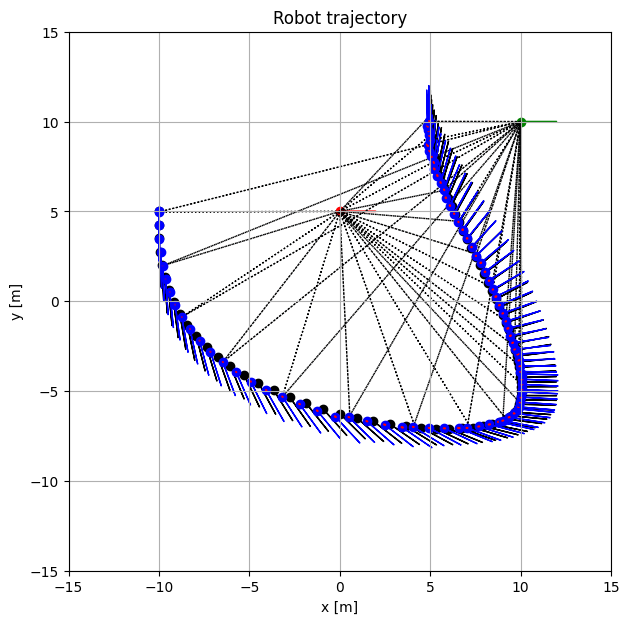

In [6]:
# generate reference trajectory

# Noises
R_b = 0.0009
R_r = 0.001
R_w = 0.0002
R_a = 0.004

dt = 0.01
x0 = np.zeros((mf.STATE_LEN, 1))
xf = np.zeros((mf.STATE_LEN, 1))
xf2 = np.zeros((mf.STATE_LEN, 1))
x0[:6] = np.array([[-1.57],[0],[-10],[5],[0],[-3]])
xf[:6] = np.array([[0],[0],[10],[-5],[0],[1]])
xf2[:6] = np.array([[1.57],[0],[5],[10],[0],[1]])
pos1, y_IMU1 = traj.gen_poly_traj(x0, xf, t0=0, tf=10, dt=dt)
pos2, y_IMU2 = traj.gen_poly_traj(xf, xf2, t0=0, tf=10, dt=dt)
pos = np.append(pos1, pos2, axis=1)
y_IMU = np.append(y_IMU1, y_IMU2, axis=1)
y_IMU = traj.gen_noise(y_IMU, dt=1, sigma=np.diag([R_w, R_a, R_a]), bias=np.array([[0.005],[0.06],[0.06]]))

xai = np.zeros((mf.STATE_LEN, 1)); xai[mf.X_P] = np.array([[0],[5]])
xaj = np.zeros((mf.STATE_LEN, 1)); xaj[mf.X_P] = np.array([[10],[10]])
pos_len = pos.shape[1]

# set noise sources:
Q=np.diag([0.1, 8.0, 8.0, 0.000001, 0.00001, 0.00001])
R=np.diag([R_b, R_r, R_w, R_a, R_a]) # approx vaules from datasheets

# Setup robots and anchors:
roboti = sim.Robot_single(x0=x0, path=pos, imu=y_IMU, dt=dt, Q=Q, R=R)
anchori = sim.Anchor(x0=xai)
anchorj = sim.Anchor(x0=xaj)

# Setup plot:
fig, ax = rp.setup_plot()
rp.plot_position(ax, pos[:,::25], color='black')
anchori.draw_position(ax, color='red')
anchorj.draw_position(ax, color='green')
roboti.draw_position(ax, color='blue')

# Run algorithm:
for i in range(pos_len-1):
    roboti.predict()
    if (i % 100 == 0):
        roboti.anchor_meas(anchori, ax, sr=R_r, sb=R_b)
    if (i % 100 == 0):
        roboti.anchor_meas(anchorj, ax, sr=R_r, sb=R_b)
    if (i % 25 == 0):
        roboti.draw_position(ax, color='blue')

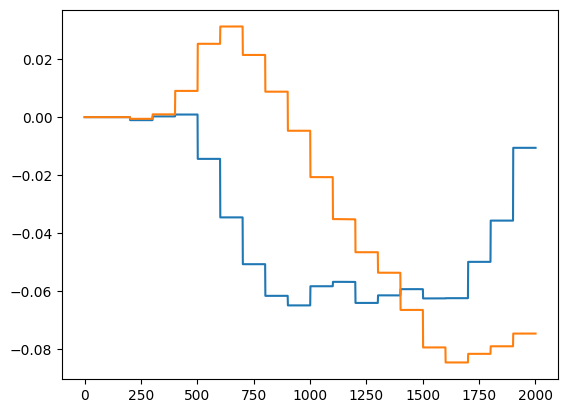

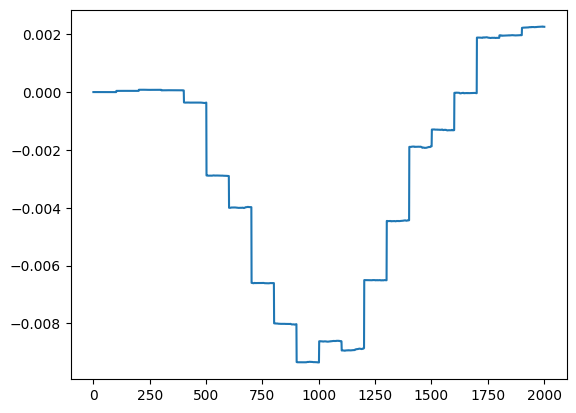

In [7]:
# Plot the bias states:
x_log = roboti.x_log
# For acc:
plt.figure()
plt.plot(x_log[9,:])
plt.plot(x_log[10,:])
plt.figure()
plt.plot(x_log[8,:])